In [1]:
#####Hierarchical structured latent logistic regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
#要素ごとのユニーク数を設定
k = 10
hh = 5000
item = 10000
tag = 250
category = 200
max_m = 20
k_vec = np.repeat(1, k)
m_vec = np.repeat(1, max_m)

#要素ごとの頻度を生成
pt = np.random.poisson(np.random.gamma(30.0, 1/0.2, hh))
N = np.sum(pt)
m = np.random.poisson(6.5, N)
m[m==0] = 1; m[m >= max_m] = max_m
max_m = np.max(m)
M = np.sum(m)

In [4]:
##idとインデックスの設定
#idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
m_id = np.repeat(np.arange(N), m)

#インデックスの設定
freq_m = np.repeat(0, hh)
d_index = [i for i in range(hh)]
m_index = [i for i in range(N)]
for i in range(hh):
    d_index[i] = np.array(np.where(d_id==i)[0], dtype="int")
    freq_m[i] = np.sum(m[d_index[i]])
for i in range(N):
    if i==0:
        m_index[i] = np.arange(m[0])
    else:
        m_index[i] = np.max(m_index[i-1]) + np.arange(m[i]) + 1
freq_id = np.repeat(np.arange(hh), freq_m)

In [5]:
##アイテムの生成
#多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_topic = np.random.dirichlet(np.repeat(0.2, item), topic)
z = np.array(rmnom(theta_topic[np.repeat(d_id, m), ], M, topic, np.arange(M), 0), dtype="int")

#トピックからアイテムを生成
item_id = np.repeat(0, M)
item_dt = np.full((N, np.max(m)), item, dtype="int16")
for i in range(N):
    if i%100000==0:
        print(i)
    index = m_index[i]
    target_z = z[index]
    while True:
        temp_id = np.array(rmnom(phi_topic[target_z, ], m[i], item, np.arange(m[i]), 0), dtype="int16")
        if np.unique(temp_id).shape[0]==m[i]:
            item_id[index] = temp_id
            item_dt[i, np.arange(m[i])] = temp_id
            break

0
100000
200000
300000
400000
500000
600000
700000


In [6]:
##アイテムにカテゴリを割り当て
#多項分布からトピックを生成
topic = 20
phi_tag = np.random.dirichlet(np.repeat(0.25, tag), topic)
phi_category = np.random.dirichlet(np.repeat(0.25, category), topic)
z = np.dot(np.random.multinomial(1, np.random.dirichlet(np.repeat(1.0, topic)), item), np.arange(topic))

#トピックからカテゴリを割り当て
tag_id = np.array(rmnom(phi_tag[z, ], item, tag, np.arange(item), 0), dtype="int16")
category_id = np.array(rmnom(phi_category[z, ], item, category, np.arange(item), 0), dtype="int16")

In [7]:
##インデックスを設定
#変数割当のインデックス
allocation_index = [j for j in range(max_m)]
allocation_item = [j for j in range(max_m)]
for j in range(max_m):
    allocation_index[j] = np.array(np.where(item_dt[:, j]!=item)[0], dtype="int")
    allocation_item[j] = item_dt[allocation_index[j], j]
    
#アイテムのインデックス
item_index = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_index[i] = np.array(np.where(np.sum(item_dt==i, axis=1)==1)[0], dtype="int")
    item_n[i] = item_index[i].shape[0]
    
#タグとカテゴリーのインデックス
tag_index = [j for j in range(tag)]
category_index = [j for j in range(category)]
tag_n = np.repeat(0, tag)
category_n = np.repeat(0, category)
for j in range(tag):
    tag_index[j] = np.array(np.where(tag_id==j)[0], dtype="int")
    tag_n[j] = tag_index[j].shape[0]
for j in range(category):
    category_index[j] = np.array(np.where(category_id==j)[0], dtype="int")
    category_n[j] = category_index[j].shape[0]

In [8]:
##応答変数を生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    
    #タグとカテゴリーの階層モデルのパラメータを生成
    alpha_g = np.repeat(0, k)
    alpha_c = np.repeat(0, k)
    tau_g = np.diag(np.random.uniform(0.1, 0.25, k))
    tau_c = np.diag(np.random.uniform(0.1, 0.25, k))
    alphat_g = alpha_g.copy(); alphat_c = alpha_c.copy()
    taut_g = tau_g.copy(); taut_c = tau_c.copy()

    #ユーザーとアイテムの階層モデルのパラメータを生成
    alpha_u = np.repeat(0, k)
    alpha_v = np.random.normal(0, 0.4, k*k).reshape(k, k)
    theta_g = np.random.multivariate_normal(alpha_g, tau_g, tag)
    theta_c = np.random.multivariate_normal(alpha_c, tau_c, category)
    theta_gc = np.dot(theta_g[tag_id, ] * theta_c[category_id, ], alpha_v)
    tau_u = np.array([1.5])
    Cov_u = np.diag(np.random.uniform(0.2, 0.75, k))
    Cov_v = np.diag(np.random.uniform(0.1, 0.25, k))
    alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy(); thetat_g = theta_g.copy(); thetat_c = theta_c.copy()
    taut_u = tau_u.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v

    #モデルパラメータを生成
    beta = np.array([-1.0])
    beta_u = np.random.normal(0, tau_u, hh)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    theta_v = np.zeros((item, k))
    for i in range(item):
        theta_v[i, ] = np.random.multivariate_normal(theta_gc[i, ], Cov_v, 1)
    betat = beta.copy(); betat_u = beta_u.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy()
        
    #モデルの期待値
    theta_item = np.zeros((N, k))
    for j in range(max_m):
        index = allocation_item[j]
        theta_item[allocation_index[j], ] += theta_v[index, ]
    uv = np.sum(theta_u[d_id, ] * theta_item, axis=1)
    mu = beta + beta_u[d_id] + uv

    #ベルヌーイ分布から応答変数を生成
    Prob = np.exp(mu) / (1 + np.exp(mu))
    y = np.random.binomial(1, Prob, N)
    y_vec = y[:, np.newaxis]

    #break条件
    if (np.mean(y) > 0.2) & (np.mean(y) < 0.4):
        break

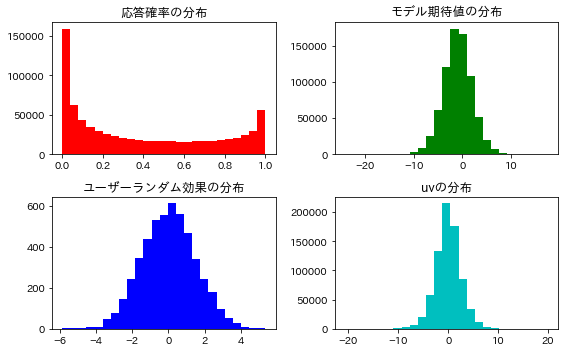

In [9]:
#潜在変数ごとのヒストグラム
dt = [Prob, mu, beta_u, uv]
fig_range = np.append(np.array([0, np.min(mu), np.min(beta_u), np.min(uv)]), 
                      np.array([1.0, np.max(mu), np.max(beta_u), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーランダム効果の分布", "uvの分布"]
fig = plt.figure(figsize=(8.0, 5.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####テストデータの生成####
##データの設定
pt0 = np.random.poisson(np.random.gamma(20.0, 1/0.25, hh))
N0 = np.sum(pt0)
m0 = np.random.poisson(6.5, N0)
m0[m0==0] = 1; m0[m0 >= max_m] = max_m
M0 = np.sum(m0)

In [11]:
##idとインデックスの設定
#idの設定
d_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))
m_id0 = np.repeat(np.arange(N0), m0)

#インデックスの設定
freq_m0 = np.repeat(0, hh)
d_index0 = [i for i in range(hh)]
m_index0 = [i for i in range(N0)]
for i in range(hh):
    d_index0[i] = np.array(np.where(d_id0==i)[0], dtype="int")
    freq_m0[i] = np.sum(m[d_index0[i]])
for i in range(N0):
    if i==0:
        m_index0[i] = np.arange(m0[0])
    else:
        m_index0[i] = np.max(m_index0[i-1]) + np.arange(m0[i]) + 1
freq_id0 = np.repeat(np.arange(hh), freq_m0)

In [12]:
##アイテムの生成
#多項分布からトピックを生成
z = np.array(rmnom(theta_topic[np.repeat(d_id0, m0), ], M0, topic, np.arange(M0), 0), dtype="int")

#トピックからアイテムを生成
item_id0 = np.repeat(0, M0)
item_dt0 = np.full((N0, max_m), item, dtype="int16")
for i in range(N0):
    if i%100000==0:
        print(i)
    index = m_index0[i]
    target_z = z[index]
    while True:
        temp_id = np.array(rmnom(phi_topic[target_z, ], m0[i], item, np.arange(m0[i]), 0), dtype="int16")
        if np.unique(temp_id).shape[0]==m0[i]:
            item_id0[index] = temp_id
            item_dt0[i, np.arange(m0[i])] = temp_id
            break

0
100000
200000
300000


In [13]:
##インデックスを設定
#変数割当のインデックス
allocation_index0 = [j for j in range(max_m)]
allocation_item0 = [j for j in range(max_m)]
for j in range(max_m):
    allocation_index0[j] = np.array(np.where(item_dt0[:, j]!=item)[0], dtype="int")
    allocation_item0[j] = item_dt0[allocation_index0[j], j]

#アイテムのインデックス
item_index0 = [i for i in range(item)]
item_n0 = np.repeat(0, item)
for i in range(item):
    item_index0[i] = np.array(np.where(np.sum(item_dt0==i, axis=1)==1)[0], dtype="int")
    item_n0[i] = item_index0[i].shape[0]

In [14]:
##応答変数を生成
#モデルの期待値
theta_item0 = np.zeros((N0, k))
for j in range(max_m):
    index = allocation_item0[j]
    theta_item0[allocation_index0[j], ] += thetat_v[index, ]
uv = np.sum(thetat_u[d_id0, ] * theta_item0, axis=1)
mu = betat + betat_u[d_id0] + uv

#ベルヌーイ分布から応答変数を生成
Prob = np.exp(mu) / (1 + np.exp(mu))
y0 = np.random.binomial(1, Prob, N0)

In [15]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##HMCでパラメータを推定するための関数
#対数事後分布の和を計算する関数
def Posterior(y, mu, theta, alpha_mu, inv_Cov, index, n, k, pattern1, pattern2):
    #ロジットモデルの対数尤度
    logit_exp = np.exp(mu)   #ロジットの期待値の指数
    Prob = logit_exp / (1 + logit_exp)
    LLho = y*np.log(Prob) + (1-y)*np.log(1-Prob)

    #多変量正規分布の対数事前分布
    er = theta - alpha_mu   #パラメータの誤差
    if pattern1==1:
        LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))
    else:
        LLi_mvn = -1/2 * er * inv_Cov * er 

    #対数事後分布の和
    if pattern2==1:
        LL = np.repeat(0.0, n)
        for i in range(n):
            LL[i] = np.sum(LLho[index[i], ]) + LLi_mvn[i]
    else:
        LL = np.sum(LLho) + LLi_mvn
    return LL, LLho

In [16]:
#期待値パラメータの勾配を計算する関数
def dloglike(beta, beta_vec, uv, tau, y):
    #応答確率の定義
    logit_exp = np.exp(beta + beta_vec + uv)
    Prob = logit_exp / (1 + logit_exp)

    #対数事後分布の微分関数の和
    dlogit = y - Prob
    dnorm = -beta / tau
    dlogit_sums = np.sum(dlogit) + dnorm
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, beta_vec, uv, tau, y) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, beta_vec, uv, tau, y) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [17]:
#ランダム効果の勾配ベクトルを計算する関数
def dloglike_r(beta_u, beta, uv, tau_u, d_id, d_index, hh):
    #応答確率の定義
    logit_exp = np.exp(beta + beta_u[d_id, ] + uv)
    Prob = logit_exp / (1 + logit_exp)

    #微分関数の設定
    dlogit = y - Prob
    dnorm = -beta_u / tau_u

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.repeat(0.0, hh)
    for i in range(hh):
        dlogit_sums[i] = np.sum(dlogit[d_index[i]]) + dnorm[i]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_r(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, beta, uv, tau_u, d_id, d_index, hh) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, beta, uv, tau_u, d_id, d_index, hh) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [18]:
#ユーザー特徴ベクトルの事後分布の勾配ベクトルを計算する関数
def dloglike_u(theta_u, theta_item, beta, beta_vec, alpha_u, inv_Cov_u, y_vec, d_id, d_index, hh, k, k_vec):
    #応答確率の定義
    uv = np.dot(theta_u[d_id, ] * theta_item, k_vec)
    logit_exp = np.exp(beta + beta_vec + uv)
    Prob = logit_exp / (1 + logit_exp)

    #微分関数の設定
    er = theta_u - alpha_u   #パラメータの誤差
    dlogit = y_vec*theta_item - Prob[:, np.newaxis]*theta_item
    dmvn = -np.dot(inv_Cov_u, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[d_index[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_u(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_item, beta, beta_vec, alpha_u, inv_Cov_u, y_vec, d_id, d_index, hh, k, k_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_item, beta, beta_vec, alpha_u, inv_Cov_u, y_vec, d_id, d_index, hh, k, k_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [19]:
#アイテム特徴ベクトルの事後分布の勾配ベクトルを計算する関数
def dloglike_v(theta_v, theta_u1, beta, beta_vec, theta_gc, inv_Cov_v, y_vec, item_id, item_index, allocation_item,
               allocation_index, item, k, k_vec):
    #アイテム特徴ベクトルの和
    theta_item = np.zeros((N, k))
    for j in range(max_m):
        index = allocation_item[j]
        theta_item[allocation_index[j], ] += theta_v[index, ]

    #応答確率の定義
    uv = np.dot(theta_u1 * theta_item, k_vec)
    logit_exp = np.exp(beta + beta_vec + uv)
    Prob = logit_exp / (1 + logit_exp)
    Prob_vec = Prob[:, np.newaxis]
    
    #対数事後分布の微分関数の和
    er = theta_v - theta_gc   #パラメータの誤差
    dmvn = -np.dot(inv_Cov_v, er.T).T
    dlogit_sums = np.zeros((item, k))
    for i in range(item):
        index = item_index[i]
        dlogit_sums[i, ] = np.sum(y_vec[index, ]*theta_u1[index, ] - Prob_vec[index, ]*theta_u1[index, ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_v(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_u1, beta, beta_vec, theta_gc, inv_Cov_v, y_vec, item_id, item_index, allocation_item,
                       allocation_index, item, k, k_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_u1, beta, beta_vec, theta_gc, inv_Cov_v, y_vec, item_id, item_index, allocation_item,
                        allocation_index, item, k, k_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [20]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [21]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 10
burnin = int(100/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.075
e3 = 0.01
L = 3

In [22]:
##データの設定
#タグ特徴ベクトルのインデックス
tag_list1 = [j for j in range(tag)]
tag_list2 = [j for j in range(tag)]
for j in range(tag):
    index = tag_index[j]
    tag_list1[j] = np.repeat(category_id[index], k)
    tag_list2[j] = np.tile(np.arange(k), index.shape[0])
    
#カテゴリ特徴ベクトルのインデックス
category_list1 = [j for j in range(category)]
category_list2 = [j for j in range(category)]
for j in range(category):
    index = category_index[j]
    category_list1[j] = np.repeat(tag_id[index], k)
    category_list2[j] = np.tile(np.arange(k), index.shape[0])

In [23]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
ADelta = np.diag(np.repeat(0.1, k))
Deltabar = np.full((k, k), 0.0)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [24]:
##パラメータの真値
#タグとカテゴリーの階層モデルのパラメータを生成
alpha_g = alphat_g.copy()
alpha_c = alphat_c.copy()
tau_g = taut_g.copy()
tau_c = taut_c.copy()
inv_tau_g = np.linalg.inv(tau_g)
inv_tau_c = np.linalg.inv(tau_c)

#ユーザーとアイテムの階層モデルのパラメータを生成
alpha_u = alphat_u.copy()
alpha_v = alphat_v.copy()
theta_g = thetat_g.copy()
theta_c = thetat_c.copy()
theta_gc = np.dot(theta_g[tag_id, ] * theta_c[category_id, ], alpha_v)
tau_u = taut_u.copy()
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータを生成
Sigma = 1.0
beta = betat.copy()
beta_u = betat_u.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()

#モデルの期待値
beta_vec = beta_u[d_id]
theta_item = np.zeros((N, k))
for j in range(max_m):
    index = allocation_item[j]
    theta_item[allocation_index[j], ] += theta_v[index, ]
uv = np.sum(theta_u[d_id, ] * theta_item, axis=1)
mu = beta + beta_vec + uv

In [25]:
##パラメータの初期値
#タグとカテゴリーの階層モデルのパラメータの初期値
alpha_g = np.repeat(0, k)
alpha_c = np.repeat(0, k)
tau_g = np.diag(np.repeat(1.0, k))
tau_c = np.diag(np.repeat(1.0, k))
inv_tau_g = np.linalg.inv(tau_g)
inv_tau_c = np.linalg.inv(tau_c)

#ユーザーとアイテムの階層モデルのパラメータの初期値
alpha_u = np.repeat(0, k)
alpha_v = np.zeros((k, k))
theta_g = np.random.multivariate_normal(alpha_g, np.diag(np.repeat(0.1, k)), tag)
theta_c = np.random.multivariate_normal(alpha_c, np.diag(np.repeat(0.1, k)), category)
theta_gc = np.zeros((item, k))
tau_u = np.array([1.0])
Cov_u = np.diag(np.repeat(1.0, k))
Cov_v = np.diag(np.repeat(1.0, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータを生成
beta = np.array([-1.0])
beta_u = np.random.normal(0, tau_u, hh)
theta_u = np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.01, k)) , hh)
theta_v = np.zeros((item, k))
for i in range(item):
    theta_v[i, ] = np.random.multivariate_normal(theta_gc[i, ], np.diag(np.repeat(0.01, k)), 1)
    
#モデルの期待値
theta_item = np.zeros((N, k))
for j in range(max_m):
    index = allocation_item[j]
    theta_item[allocation_index[j], ] += theta_v[index, ]
uv = np.sum(theta_u[d_id, ] * theta_item, axis=1)
logit_exp = np.exp(beta + beta_u[d_id] + uv)

In [26]:
##パラメータの格納用配列
#タグとカテゴリーの階層モデルのパラメータの格納用配列
TAU_G = np.zeros((k, k, int(R/keep)))
TAU_C = np.zeros((k, k, int(R/keep)))

#ユーザーとアイテムの階層モデルのパラメータの格納用配列
ALPHA_V = np.zeros((k, k, int(R/keep)))
THETA_G = np.zeros((tag, k, int(R/keep)))
THETA_C = np.zeros((category, k, int(R/keep)))
TAU_U = np.repeat(0.0, int(R/keep))
COV_U = np.zeros((k, k, int(R/keep)))
COV_V = np.zeros((k, k, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
BETA_U = np.zeros((int(R/keep), hh))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))

In [27]:
##対数尤度の基準値
#学習データに対する1パラメータモデルの対数尤度
Prob = norm.cdf(np.mean(y), 0, Sigma)
LLst = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLst)

#学習データに対する真値での対数尤度
thetat_item = np.zeros((N, k))
for j in range(max_m):
    index = allocation_item[j]
    thetat_item[allocation_index[j], ] += thetat_v[index, ]
logit = betat + betat_u[d_id] + np.sum(thetat_u[d_id, ] * thetat_item, axis=1)
Prob = np.exp(logit) / (1 + np.exp(logit))
LLbest = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLbest)


#テストデータに対する1パラメータモデルの対数尤度
Prob = norm.cdf(np.mean(y), 0, Sigma)
LLst0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
print(LLst0)

#テストデータに対する真値での対数尤度
thetat_item = np.zeros((N0, k))
for j in range(max_m):
    index = allocation_item0[j]
    thetat_item[allocation_index0[j], ] += thetat_v[index, ]
logit = betat + betat_u[d_id0] + np.sum(thetat_u[d_id0, ] * thetat_item, axis=1)
Prob = np.exp(logit) / (1 + np.exp(logit))
LLbest0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
print(LLbest0)

-608818.7448390415
-271861.44641863904
-324178.1186987681
-144315.70943646322


In [30]:
##モデルの期待値パラメータをサンプリング
for rp in range(R):
    
    ##期待値パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, 1)
    betad = beta.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, betad, dloglike, e1, L)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    mu_new = betan + beta_vec + uv   #期待値を更新
    Hnew = -Posterior(y, mu_new, betan, 0, 1/tau, d_index, hh, 1, 0, 0)[0] + np.power(rnew, 2)/2
    Hold = -Posterior(y, mu, betad, 0, 1/tau, d_index, hh, 1, 0, 0)[0] + np.power(rold, 2)/2

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, 1)
    alpha = np.min(np.append(1, np.exp(Hold - Hnew)))
    alpha1 = alpha.copy()

    #alphaの値に基づき新しいbetaを採択
    flag = np.array((alpha > rand), dtype="int")
    beta = flag*betan + (1-flag)*betad
    if flag==1:
        mu = mu_new.copy()


    ##ランダム効果をサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, hh)
    betad_u = beta_u.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog_r(rold, betad_u, dloglike_r, e2, L)
    rnew = res[0]
    betan_u = res[1]

    #移動前と移動後のハミルトニアン
    mu_new = beta + betan_u[d_id] + uv   #期待値を更新
    Hnew = -Posterior(y, mu_new, betan_u, 0, 1/tau_u, d_index, hh, 1, 0, 1)[0] + np.power(rnew, 2)/2
    Hold = -Posterior(y, mu, betad_u, 0, 1/tau_u, d_index, hh, 1, 0, 1)[0] + np.power(rold, 2)/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    alpha = np.min(np.hstack((np.repeat(1, hh)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    alpha2 = alpha.copy()

    #alphaの値に基づき新しいthetaを採択
    flag = np.array(alpha > rand, dtype="int")
    beta_u = flag*betan_u + (1-flag)*betad_u; beta_vec = beta_u[d_id]
    mu = beta + beta_vec + uv


    ##ユーザー特徴ベクトルをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1.0, k)), hh)
    thetad_u = theta_u.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog_u(rold, thetad_u, dloglike_u, e2, L)
    rnew = res[0]
    thetan_u = res[1]

    #移動前と移動後のハミルトニアン
    mu_new = beta + beta_vec + np.sum(thetan_u[d_id, ] * theta_item, axis=1)
    Hnew = -Posterior(y, mu_new, thetan_u, alpha_u, inv_Cov_u, d_index, hh, k, 1, 1)[0] + np.dot(np.power(rnew, 2), k_vec)/2
    Hold = -Posterior(y, mu, thetad_u, alpha_u, inv_Cov_u, d_index, hh, k, 1, 1)[0] + np.dot(np.power(rold, 2), k_vec)/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    alpha = np.min(np.hstack((np.repeat(1, hh)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    alpha3 = alpha.copy()

    #alphaの値に基づき新しい特徴ベクトルを採択
    flag = np.array(alpha > rand, dtype="int")[:, np.newaxis]
    theta_u = flag*thetan_u + (1-flag)*thetad_u; theta_u1 = theta_u[d_id, ]
    uv = np.sum(theta_u1 * theta_item, axis=1)
    mu = beta + beta_vec + uv


    ##アイテム特徴ベクトルをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1.0, k)), item)
    thetad_v = theta_v.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog_v(rold, thetad_v, dloglike_v, e3, L)
    rnew = res[0]
    thetan_v = res[1]

    #アイテム特徴ベクトルの和と期待値を更新
    theta_item = np.zeros((N, k))
    for j in range(max_m):
        index = allocation_item[j]
        theta_item[allocation_index[j], ] += thetan_v[index, ]
    mu_new = beta + beta_vec + np.sum(theta_u1 * theta_item, axis=1)

    #移動前と移動後のハミルトニアン
    Hnew = -Posterior(y, mu_new, thetan_v, theta_gc, inv_Cov_v, item_index, item, k, 1, 1)[0] + np.dot(np.power(rnew, 2), k_vec)/2
    Hold = -Posterior(y, mu, thetad_v, theta_gc, inv_Cov_v, item_index, item, k, 1, 1)[0] + np.dot(np.power(rold, 2), k_vec)/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, item)
    alpha = np.min(np.hstack((np.repeat(1, item)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    alpha4 = alpha.copy()

    #alphaの値に基づき新しい特徴ベクトルを採択
    flag = np.array(alpha > rand, dtype="int")[:, np.newaxis]
    theta_v = flag*thetan_v + (1-flag)*thetad_v
    
    #アイテム特徴ベクトルの和と期待値を更新
    theta_item = np.zeros((N, k))
    for j in range(max_m):
        index = allocation_item[j]
        theta_item[allocation_index[j], ] += theta_v[index, ]
    uv = np.sum(theta_u1 * theta_item, axis=1)
    mu = beta + beta_vec + uv


    ##階層モデルのパラメータをサンプリング
    #ランダム効果の分散をサンプリング
    er_u = beta_u - np.mean(beta_u)
    s1 = np.sum(np.power(er_u, 2)) + s01
    s2 = hh + s02
    tau_u = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))

    #ユーザーの特徴ベクトルの分散共分散行列をサンプリング
    er_u = theta_u - np.mean(theta_u, axis=0)
    IW_R = np.dot(er_u.T, er_u) + V
    Sn = hh + nu
    Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_u = np.linalg.inv(Cov_u)


    ##アイテム特徴ベクトルの階層モデルのパラメータをサンプリング
    #タグ特徴ベクトルの事後分布をサンプリング
    Cov_mu = np.mean(np.diag(Cov_u))
    for j in range(tag):
        index = tag_index[j]
        x1 = theta_c[tag_list1[j], ] * alpha_v.T[tag_list2[j], ]; y1 = theta_v[index, ].reshape(-1)
        xy = np.dot(x1.T, y1)
        xxv = np.dot(x1.T, x1) + inv_tau_g
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_tau_g, alpha_g))
        theta_g[j, ] = np.random.multivariate_normal(theta_par, Cov_mu*inv_xxv, 1)

    #カテゴリー特徴ベクトルの事後分布をサンプリング
    for j in range(category):
        index = category_index[j]
        x1 = theta_g[category_list1[j], ] * alpha_v.T[category_list2[j], ]; y1 = theta_v[index, ].reshape(-1)
        xy = np.dot(x1.T, y1)
        xxv = np.dot(x1.T, x1) + inv_tau_g
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_tau_g, alpha_g))
        theta_c[j, ] = np.random.multivariate_normal(theta_par, Cov_mu*inv_xxv, 1)

    #回帰行列と分散共分散行列の事後分布をサンプリング
    x1 = theta_g[tag_id, ] * theta_c[category_id, ]; y1 = theta_v.copy()
    xy = np.dot(x1.T, y1)
    inv_xxv = np.linalg.inv(np.dot(x1.T, x1) + ADelta)
    res = rmultireg(y1, x1, inv_xxv, xy, Cov_u, ADelta, Deltabar, V, nu, item, k, k)
    alpha_v = res[0]
    Cov_v = np.diag(np.diag(res[1]))
    inv_Cov_v = np.linalg.inv(Cov_u)

    #アイテム特徴ベクトルの期待値の事前分布を更新
    theta_gc = np.dot(theta_g[tag_id, ] * theta_c[category_id, ], alpha_v)


    ##タグとカテゴリー特徴ベクトルの階層モデルのパラメータをサンプリング
    #タグ特徴ベクトルの分散共分散行列をサンプリング
    er_g = theta_g - np.mean(theta_g, axis=0)
    IW_R = np.dot(er_g.T, er_g) + V
    Sn = tag + nu
    Cov_g = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_g = np.linalg.inv(Cov_g)

    #カテゴリー特徴ベクトルの分散共分散行列をサンプリング
    er_c = theta_g - np.mean(theta_c, axis=0)
    IW_R = np.dot(er_c.T, er_c) + V
    Sn = category + nu
    Cov_c = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_c = np.linalg.inv(Cov_c)


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        TAU_G[:, :, mkeep] = tau_g
        TAU_C[:, :, mkeep] = tau_c
        ALPHA_V[:, :, mkeep] = alpha_v
        THETA_G[:, :, mkeep] = theta_g
        THETA_C[:, :, mkeep] = theta_c
        TAU_U[mkeep, ] = tau_u
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v
        BETA[mkeep] = beta
        BETA_U[mkeep, ] = beta_u
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v

    if rp%disp==0:
        #学習データに対する対数尤度を更新
        logit_exp = np.exp(mu)
        Prob = logit_exp / (1 + logit_exp)
        LL = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))

        #テストデータに対する対数尤度を更新
        theta_item0 = np.zeros((N0, k))
        for j in range(max_m):
            index = allocation_item0[j]
            theta_item0[allocation_index0[j], ] += theta_v[index, ]
        logit_exp = np.exp(beta + beta_u[d_id0] + np.sum(theta_u[d_id0, ] * theta_item0, axis=1))
        Prob = logit_exp / (1 + logit_exp)
        LL0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))

        #サンプリング結果の表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))   #学習用データに対する対数尤度
        print(np.round(np.array((LL0, LLbest0, LLst0)), 1))   #テストデータに対する対数尤度
        print(np.round(np.array([alpha1, np.mean(alpha2), np.mean(alpha3), np.mean(alpha4)]), 3))    

0
[-443611.7 -271861.4 -608818.7]
[-244404.2 -144315.7 -324178.1]
[1.    0.986 0.543 0.859]
10
[-442066.5 -271861.4 -608818.7]
[-244361.7 -144315.7 -324178.1]
[0.965 0.986 0.947 0.857]
20
[-441828.3 -271861.4 -608818.7]
[-244396.2 -144315.7 -324178.1]
[1.    0.986 0.944 0.859]
30
[-441453.2 -271861.4 -608818.7]
[-244570.  -144315.7 -324178.1]
[1.    0.986 0.945 0.863]
40
[-441217.9 -271861.4 -608818.7]
[-244689.7 -144315.7 -324178.1]
[1.    0.986 0.944 0.856]
50
[-441268.6 -271861.4 -608818.7]
[-244281.7 -144315.7 -324178.1]
[1.    0.986 0.94  0.861]
60
[-440835.8 -271861.4 -608818.7]
[-244632.1 -144315.7 -324178.1]
[1.    0.986 0.941 0.855]
70
[-440379.2 -271861.4 -608818.7]
[-244824.3 -144315.7 -324178.1]
[0.936 0.986 0.945 0.87 ]
80
[-440019.1 -271861.4 -608818.7]
[-245000.9 -144315.7 -324178.1]
[1.    0.986 0.947 0.857]
90
[-439931.9 -271861.4 -608818.7]
[-245135.4 -144315.7 -324178.1]
[1.    0.986 0.945 0.856]
100
[-439432.6 -271861.4 -608818.7]
[-245352.3 -144315.7 -324178.1]
[0.

880
[-324089.2 -271861.4 -608818.7]
[-235086.1 -144315.7 -324178.1]
[0.99  0.991 0.948 0.785]
890
[-323584.5 -271861.4 -608818.7]
[-235275.4 -144315.7 -324178.1]
[1.    0.991 0.946 0.787]
900
[-323027.3 -271861.4 -608818.7]
[-235594.5 -144315.7 -324178.1]
[0.998 0.991 0.945 0.795]
910
[-322528.3 -271861.4 -608818.7]
[-235554.9 -144315.7 -324178.1]
[1.    0.991 0.944 0.792]
920
[-321842.  -271861.4 -608818.7]
[-235977.  -144315.7 -324178.1]
[0.979 0.991 0.944 0.785]
930
[-321712.1 -271861.4 -608818.7]
[-235179.4 -144315.7 -324178.1]
[0.944 0.991 0.944 0.802]
940
[-321191.1 -271861.4 -608818.7]
[-235517.5 -144315.7 -324178.1]
[0.994 0.991 0.945 0.799]
950
[-320525.5 -271861.4 -608818.7]
[-235979.8 -144315.7 -324178.1]
[1.    0.991 0.946 0.778]
960
[-319810.2 -271861.4 -608818.7]
[-235519.5 -144315.7 -324178.1]
[0.983 0.992 0.946 0.79 ]
970
[-319496.  -271861.4 -608818.7]
[-235961.1 -144315.7 -324178.1]
[1.    0.991 0.945 0.793]
980
[-318925.1 -271861.4 -608818.7]
[-235439.3 -144315.7 -32

1750
[-290313.1 -271861.4 -608818.7]
[-235080.8 -144315.7 -324178.1]
[0.969 0.993 0.935 0.789]
1760
[-290145.5 -271861.4 -608818.7]
[-235298.4 -144315.7 -324178.1]
[1.    0.992 0.936 0.778]
1770
[-289798.2 -271861.4 -608818.7]
[-235248.3 -144315.7 -324178.1]
[1.    0.993 0.938 0.796]
1780
[-289897.3 -271861.4 -608818.7]
[-235524.5 -144315.7 -324178.1]
[1.    0.992 0.936 0.784]
1790
[-289717.4 -271861.4 -608818.7]
[-235358.3 -144315.7 -324178.1]
[0.967 0.992 0.937 0.793]
1800
[-289388.1 -271861.4 -608818.7]
[-235068.5 -144315.7 -324178.1]
[1.    0.992 0.935 0.803]
1810
[-289687.8 -271861.4 -608818.7]
[-235065.1 -144315.7 -324178.1]
[1.    0.993 0.935 0.778]
1820
[-289162.2 -271861.4 -608818.7]
[-234751.1 -144315.7 -324178.1]
[0.99  0.993 0.937 0.791]
1830
[-289098.4 -271861.4 -608818.7]
[-234999.2 -144315.7 -324178.1]
[1.    0.993 0.935 0.782]
1840
[-289128.3 -271861.4 -608818.7]
[-235340.1 -144315.7 -324178.1]
[1.    0.992 0.935 0.792]
1850
[-288782.4 -271861.4 -608818.7]
[-235512.1 -1